# Imports

In [ ]:
import os
import re
import pandas as pd
import numpy as np
from natsort import natsorted
from scipy.integrate import simpson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

# Turbines and site

In [ ]:
po = [0, 0, 0, 0, 0, 0, 0, 49, 97, 183, 268, 369, 470, 580, 722, 
      900, 1103, 1315, 1526, 1705, 1883, 1940, 1980, 1995, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000] # https://www.thewindpower.net/turbine_en_779_vestas_v100-2000.php
ct = 0.8 * np.ones_like(po)
u = np.linspace(0, len(po), len(po))

turbine = WindTurbine(name = 'Turbines',
                      diameter = 100,
                      hub_height = 100,
                      powerCtFunction = PowerCtTabular(u, po, 'kW', ct))

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=.1))

n_rows = 1 + 12
n_cols = 1 + 12

D = turbine.diameter()
s = 10 * D

x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

theta_deg = 0
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

x = x - np.max(x) # Set x=0 at downstream edge
y = y - np.min(y) # Set y=0 at bottommost turbine

padding = 30 # Padding for display [D]

fig, ax = plt.subplots()

# Plot each turbine as a circle
for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), 1, color='black', fill=True)
    ax.add_patch(circle)

# Set padded limits
ax.set_xlim(min(x)/D - padding, max(x)/D + 5*padding)
ax.set_ylim(min(y)/D - padding, max(y)/D + padding)

# Retrieve actual limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

tick_interval = 40  # in units of D

# Generate a wide range of ticks
xticks = np.arange(-1000, 1000, tick_interval)
yticks = np.arange(-1000, 1000, tick_interval)

# Clip to axes limits
xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[1])]
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]

# Apply ticks
ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xlabel(r"$x\;[D]$")
ax.set_ylabel(r"$y\;[D]$")
ax.set_aspect('equal')
ax.grid(True)
plt.show()

# Flow map

In [ ]:
wdir = 270  # [deg]
wsp = 10  # [m/s]
ti = 0.1

mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize=(10, 6))

wfm = PropagateDownwind(site, turbine,
                        wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                        superpositionModel=LinearSum())
sim = wfm(x, y, ws=wsp, wd=wdir, TI=ti)

sim.flow_map().plot_wake_map(ax=ax, normalize_with=D, plot_windturbines=False)

for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), radius=1, color='black', fill=True)
    ax.add_patch(circle)
    
ax.set_xlabel(r"$x \; [m]$")
ax.set_ylabel(r"$y \; [m]$")
ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()

# Load validation data from TDM

In [ ]:
validation_data_path = "../ArbitraryLayouts/ValidationData"

# List only files, sorted alphabetically
validation_files = natsorted(
    [f for f in os.listdir(validation_data_path) if os.path.isfile(os.path.join(validation_data_path, f))]
)

validation_datasets = {}
for file in validation_files:
    if file.endswith('.csv'):
        file_path = os.path.join(validation_data_path, file)
        validation_datasets[file] = pd.read_csv(file_path)

print("Loaded datasets:", list(validation_datasets.keys()))

# Wind speed profiles

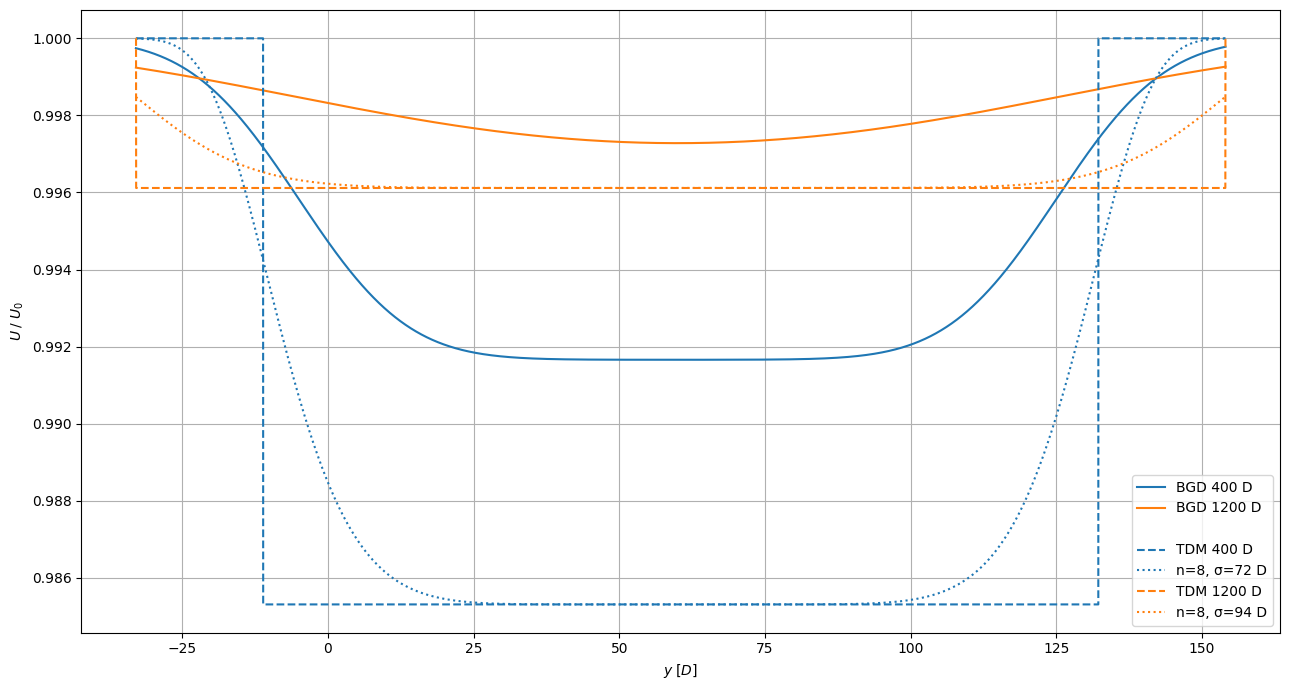

In [8]:
d_downstream = [400, 1200]
m_downstream = [d * D for d in d_downstream]

# Use the longest file to define w_meas
longest_file = max(validation_datasets, key=lambda f: len(validation_datasets[f]))

# Pad the longest file with a value of 1 at both ends
cols = validation_datasets[longest_file].columns
pad_row = pd.DataFrame([np.ones(len(cols))], columns=cols)

validation_datasets[longest_file] = pd.concat([
    pad_row,
    validation_datasets[longest_file],
    pad_row
], ignore_index=True)

w_meas = min(validation_datasets[longest_file].iloc[:, 0].values) * D  # Half-width of measurement area [m]

y_agreed = max(len(df) for df in validation_datasets.values())

y_range = np.linspace(w_meas, y_agreed + w_meas, y_agreed)
y_meas = np.tile(y_range[:, np.newaxis], (1, len(m_downstream)))  # Shape: (y_agreed, len(m_downstream))
ws_meas = np.zeros_like(y_meas)

padded_tdm = {}
tdm_lengths = {}

fig, ax = plt.subplots(figsize=(13, 7))
ax.set_xlabel(r'$y \; [D]$')
ax.set_ylabel(r'$ U \; / \; U_0 $')
ax.grid(True)

# --- PyWake profiles ---
for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)
    ws_meas[:, i] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_meas[:, i],
            h=turbine.hub_height() * np.ones_like(y_meas[:, i])
        )).WS_eff.values
    )
    ax.plot(y_meas[:, i] / D, ws_meas[:, i] / wsp, label=f'BGD {d_downstream[i]} D')

ax.plot([], [], linestyle='None', marker='', label=' ')

# --- TDM profiles ---
for i, file in enumerate(validation_files):
    match = re.search(r'(\d+)', file)
    downstream_distance = int(match.group(1)) if match else None

    tdm_data = validation_datasets[file]
    tdm_values = tdm_data.iloc[:, 1].values

    # Store original length BEFORE padding
    if downstream_distance is not None:
        tdm_lengths[downstream_distance] = len(tdm_values)

    # Symmetric padding
    if len(tdm_values) < y_agreed:
        pad_total = y_agreed - len(tdm_values)
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        tdm_values = np.pad(tdm_values, (pad_left, pad_right), constant_values=wsp / 10)

    if downstream_distance is not None:
        padded_tdm[downstream_distance] = tdm_values

    # Match to PyWake profile
    if downstream_distance in d_downstream:
        idx = d_downstream.index(downstream_distance)
    else:
        idx = i if i < len(d_downstream) else 0

    color = ax.get_lines()[idx].get_color()

    ax.plot(y_range / D, tdm_values, linestyle='--', color=color, label=f'TDM {downstream_distance} D')

    # ------------------ Flat-top Gaussian ------------------ #

    # Get center value of first column (y-coordinate) of TDM data
    y_col = tdm_data.iloc[:, 0]
    mid = len(y_col) // 2
    if len(y_col) % 2 == 0:
        y_center = (y_col.iloc[mid - 1] + y_col.iloc[mid]) / 2
        y_center = y_center * D
    else:
        y_center = y_col.iloc[mid]
        y_center = y_center * D

    # Shift y_range so it's centered around the TDM center
    y_range_centered = y_range - y_center

    A = 1 - np.min(tdm_values)
    W = tdm_lengths[downstream_distance]
    n = 8

    sigma = W / (simpson(np.exp(-2 * y_range_centered**n), x=y_range_centered))
    U_ftg = A * np.exp(- (np.abs(y_range_centered) / sigma)**n)

    # Plot using the centered x-coordinates
    plt.plot(y_range / D, 1 - U_ftg, linestyle='dotted', color=color, label=f'n={n}, σ={sigma/D:.0f} D')

    # ------------------------------------------------------- #

ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [11]:
# Momentum comparison

from collections import defaultdict

# Store total momentum values
momentum = defaultdict(dict)

for i, d in enumerate(d_downstream):
    label = f"{d} D"

    # ---- PyWake total momentum ----
    U_pywake = ws_meas[:, i] / wsp
    momentum_pywake = simpson(U_pywake**2, x=y_range)
    momentum['PyWake'][label] = momentum_pywake

    # ---- TDM total momentum ----
    U_tdm = padded_tdm[d]
    momentum_tdm = simpson(U_tdm**2, x=y_range)
    momentum['TDM'][label] = momentum_tdm

    # ---- FTG total momentum ----
    A = 1 - np.min(U_tdm)
    y_col = validation_datasets[validation_files[i]].iloc[:, 0]
    mid = len(y_col) // 2
    if len(y_col) % 2 == 0:
        y_center = (y_col.iloc[mid - 1] + y_col.iloc[mid]) / 2
    else:
        y_center = y_col.iloc[mid]
    y_center = y_center * D
    y_range_centered = y_range - y_center

    n = 8
    W = tdm_lengths[d]
    sigma = W / (simpson(np.exp(-2 * y_range_centered**n), x=y_range_centered))
    U_ftg = 1 - A * np.exp(- (np.abs(y_range_centered) / sigma)**n)
    momentum_ftg = simpson(U_ftg**2, x=y_range)
    momentum['FTG'][label] = momentum_ftg

# ---- Print results ----
print("\nTotal Momentum Comparison:")
print(f"{'Type':<10} {'Distance':<8} {'Momentum':>12} {'Rel. Error vs PyWake (%)':>30}")
for typ in ['PyWake', 'TDM', 'FTG']:
    for d in d_downstream:
        label = f"{d} D"
        m_val = momentum[typ][label]
        if typ == 'PyWake':
            rel_err = 0
        else:
            m_ref = momentum['PyWake'][label]
            rel_err = 100 * abs(m_val - m_ref) / m_ref
        print(f"{typ:<10} {label:<8} {m_val:12.4f} {rel_err:30.2f}")



Total Momentum Comparison:
Type       Distance     Momentum       Rel. Error vs PyWake (%)
PyWake     400 D      18483.4767                           0.00
PyWake     1200 D     18626.5629                           0.00
TDM        400 D      18280.9704                           1.10
TDM        1200 D     18554.0712                           0.39
FTG        400 D      18302.0426                           0.98
FTG        1200 D     18566.0693                           0.32


# Eksempel på momentumbevarende supergaussian

In [ ]:
# Constants
U0 = 0.992       # Free stream wind speed [U/U0]
W = 131.164       # Width of the uniform profile [d]

# Compute the integral ∫ exp(-2|y|^n) dy from y = -∞ to ∞
def integral_n(n):
    y = np.linspace(0, 10, 10000)
    f = np.exp(-2 * y**n)
    return 2 * simpson(f, x=y)  # Use x=y explicitly

# Compute σ such that momentum is conserved
def sigma_for_momentum(n):
    return W / integral_n(n)

# Wider x range to capture tails
x = np.linspace(-150, 150, 300)  # Cover tails up to ±3000 m
plt.figure(figsize=(10, 6))

# Plot super-Gaussian profiles
for n in [4, 8, 16, 32]:
    sigma = sigma_for_momentum(n)
    U = U0 * np.exp(- (np.abs(x) / sigma)**n)
    plt.plot(x, U, label=f'n={n}, σ={sigma:.0f} m')

# Plot uniform profile only within its defined width
U_uniform = np.where(np.abs(x) <= W/2, U0, 0)
plt.plot(x, U_uniform, 'k--', label='Uniform (width=W)')

# Final plot formatting
plt.xlabel('y [D]')
plt.ylabel('U / U0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Total wsp deficit integration

In [ ]:
rho = 1.225
integrated_m_pywake = {}
integrated_m_tdm = {}

np.trapezoid(ws_meas[:, 0], )

print('------------- INDIVIDUAL MOMENTUM -------------\n')

# PyWake and TDM integration
for i, d in enumerate(d_downstream):
    if d not in padded_tdm or d not in tdm_lengths:
        print(f"[WARNING] Missing data for {d} D")
        continue

    # Get the y-positions from the TDM file
    y_tdm = validation_datasets[validation_files[i]].iloc[:, 0].values * D
    tdm_profile = validation_datasets[validation_files[i]].iloc[:, 1].values * wsp

    # Determine the mask over y_range that falls within TDM bounds
    mask = (y_range >= y_tdm.min()) & (y_range <= y_tdm.max())

    pywake_profile = ws_meas[mask, i]

    tdm_integral = np.trapezoid(tdm_profile, y_tdm)
    pyw_integral = np.trapezoid(pywake_profile, y_range[mask])

    integrated_m_tdm[d] = rho * tdm_integral**2
    integrated_m_pywake[d] = rho * pyw_integral**2

    print(f"TDM integrated momentum at {d} D: {integrated_m_tdm[d]:.0f} kg*m/s")
    print(f"PyW integrated momentum at {d} D: {integrated_m_pywake[d]:.0f} kg*m/s")

print('\n------------- TOTAL MOMENTUM DEVIATION [%] -------------\n')

for d in d_downstream:
    if d in integrated_m_tdm and d in integrated_m_pywake:
        pyw = integrated_m_pywake[d]
        tdm = integrated_m_tdm[d]
        percent_diff = 100 * (pyw - tdm) / pyw
        print(f"TDM error at {d} D: {percent_diff:.2f}%")

print('\n------------- MOMENTUM DEFICIT DEVIATION [%] -------------\n')

for i, d in enumerate(d_downstream):
    if d not in padded_tdm or d not in tdm_lengths:
        print(f"[WARNING] Missing data for {d} D")
        continue

    y_tdm = validation_datasets[validation_files[i]].iloc[:, 0].values * D
    tdm_profile = validation_datasets[validation_files[i]].iloc[:, 1].values * wsp

    mask = (y_range >= y_tdm.min()) & (y_range <= y_tdm.max())

    pywake_profile = ws_meas[mask, i]
    y_sub = y_range[mask]

    tdm_integral = np.trapezoid(wsp - tdm_profile, y_tdm)
    pyw_integral = np.trapezoid(wsp - pywake_profile, y_sub)

    integrated_m_tdm[d] = rho * tdm_integral**2
    integrated_m_pywake[d] = rho * pyw_integral**2


for d in d_downstream:
    if d in integrated_m_tdm and d in integrated_m_pywake:
        pyw = integrated_m_pywake[d]
        tdm = integrated_m_tdm[d]
        percent_diff = 100 * (pyw - tdm) / pyw
        print(f"TDM error at {d} D: {percent_diff:.2f}%")

print('\n------------- MAXIMUM VELOCITY DEVIATION [%] -------------\n')



print('\n------------- WAKE WIDTH DEVIATION [%] -------------\n')



# Measurement lines

In [ ]:
padding = 2000

fig, ax = plt.subplots(figsize=(10, 6))
turbine.plot(x, y, ax=ax)

ax.set_xlim(min(x) - padding, max(x) + max(m_downstream) + padding)
ax.set_ylim(min(y) - padding, max(y) + padding)

# Draw vertical lines at each x_meas (same for all points in a column)
color_map = plt.get_cmap('tab10')
for i, m in enumerate(m_downstream):
    x_line = max(x) + m
    color = color_map(i % 10)
    ax.axvline(x=x_line, color=color, label=f'{d_downstream[i]} D')  # Add label for legend

ax.set_title(f"Turbine Layout with Measurement Lines ({theta_deg}° Rotation)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)

# Only show one legend entry per PL
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Remove duplicate labels
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()

# Wake min y-coord.

In [ ]:
threshold = 0.99999 * wsp

for i, d in enumerate(d_downstream):
    wake_indices = np.where(ws_meas[:, i] < threshold)[0]
    if len(wake_indices) > 0:
        lowest_y = y_range[wake_indices[0]]
        print(f"Lowest y-value of the wake at {d} D: {lowest_y/D:.0f} D")
    else:
        print(f"No wake detected at {d} D")